In [35]:
#导包
%matplotlib inline
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error
import warnings
from torch import nn
import matplotlib.pyplot as plt
import jieba
from collections import Counter
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# 读取CSV文件
def bad_line(x):
    print(x)
    return None
df = pd.read_csv('/content/drive/MyDrive/ITNewTech/movie_lable.csv', engine='python',encoding='utf-8',on_bad_lines=bad_line ,skip_blank_lines=True)

# 删除重复项
df = df.drop_duplicates()

# 填充缺失值
df = df.fillna('无')

In [3]:
#这里我想因为标签和类别的长度不一样 我想标签都取前两个 类别取前两个 然后分词 类别只有一个的情况就补一个词
#然后导演不分词 把导演名字看成一个词
#剪裁类型函数
def cut_category(category):
  num, index = 0, 0
  for i in category:
    if i == '/':
      num += 1
    if num == 2:
      return category[:index]
    index += 1
  if num == 0:
    return category + str('/单一')
  else:
    return category 
#剪裁标签函数
def cut_tag(tag):
  num, index = 0, 0
  for i in tag:
    if i == '/':
      num += 1
    if num == 1:
      return tag[:index]
    index += 1
  return tag
  
# print(df.head(2))
#通过该模型，做一个有标号的训练集
df_list = np.array(df).tolist() #直接把源文件转化成一个list准备添加标号
cnt = 0
#处理所有的类型和标签
for i in df_list:
  i[3] = cut_category(i[3])
  i[5] = cut_tag(i[5])
  # print(i[3])
  # print(i[5])
  cnt += 1
#list重新转换成df
df = pd.DataFrame(df_list, columns=['name', 'director',  'rating', 'category', 'duration', 'tag' ,'lables'])

print(df.head(5))

            name            director  rating category  duration    tag  lables
0  哈利·波特与阿兹卡班的囚徒              阿方索·卡隆     8.5    剧情/奇幻       141   哈利波特     553
1           霸王别姬                 陈凯歌     9.6    剧情/爱情       171     经典     274
2          青木瓜之味                 陈英雄     7.8    剧情/爱情       104     越南    1421
3             乡愁           安德烈·塔可夫斯基     9.0    剧情/单一       125  塔可夫斯基     509
4          云上的日子  米开朗基罗·安东尼奥尼/维姆·文德斯     7.7    剧情/爱情       105     法国    1774


In [4]:
# 分词并过滤停用词
stopwords = set(pd.read_csv('/content/drive/MyDrive/ITNewTech/stopwords.txt', sep='\t', header=None, engine='python',quoting=3,encoding='utf-8')[0])
#电影名没用，不分词
#导演看成一个词不分词
df['category'] = df['category'].apply(lambda x: ' '.join([w for w in jieba.cut(x) if w not in stopwords]))
#tag看成一个词

# 将电影名称、时长、评分和数字特征组合成新的数据框
# word_df = df[['director', 'tag', 'category', 'duration', 'rating']] #这个是去除掉电影名之后的电影属性，因为电影名没啥用
word_df = df[['tag', 'category', 'duration', 'rating']] #这个是输入的向量df
lables_df = df['lables'] #这是输出df
select_df = df[['name','director', 'tag', 'category', 'duration', 'rating','lables']] #这个df是为了到时候好查找电影名

print(word_df.head(3))
print(lables_df.head(3))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.842 seconds.
DEBUG:jieba:Loading model cost 0.842 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


    tag category  duration  rating
0  哈利波特    剧情 奇幻       141     8.5
1    经典    剧情 爱情       171     9.6
2    越南    剧情 爱情       104     7.8
0     553
1     274
2    1421
Name: lables, dtype: int64


In [5]:
#将每个电影的属性全部拼成一个分词好的字符串
line_df = list() #将每部电影属性 所有有用的词 都搞成一列 存在line_df中
select_list = np.array(select_df).tolist()
list_df = np.array(word_df).tolist()
for i in list(list_df):
    line = ''
    for j in i:
        line += ' '
        line += str(j)
    line_df.append(line)

In [6]:
# 分词并统计词频
#重新写分词函数
#拆一行的函数
def split_movie(line):
  res = []
  j = 0
  length = len(line)
  for i in range(length):
    if line[j] == ' ':
      j += 1
      continue
    if line[i] == ' ' or i == length:
      res.append(line[j:i])
      j = i
  res.append(line[-3:])
  return res


words = []
for line in line_df:
    # words += jieba.cut(line)
    #手动分词
    word_list = split_movie(line)
    for word in word_list:
      words.append(word)
word_freq = Counter(words)

In [7]:
print(words[:10])

['哈利波特', '剧情', '奇幻', '141', '8.5', '经典', '剧情', '爱情', '171', '9.6']


In [8]:
vocab_size = 1510 # 设定词汇表大小 理论上来讲 每部电影4个词加上评分和数字应该6个 10000条电影 60000个词 但是很多重复的 所以 取6500个
vocab = ["<PAD>", "<UNK>"] + [word for word, _ in word_freq.most_common(vocab_size - 2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [9]:
print(vocab)
print(vocab_size)
print(len(vocab))

['<PAD>', '<UNK>', '剧情', '单一', '喜剧', '爱情', '动画', '美国', '动作', '7.5', '7.4', '7.3', '7.2', '7.6', '0', '7.7', '法国', '7.8', '悬疑', '日本', '7.9', '惊悚', '科幻', '8.0', '8.1', '8.2', '犯罪', '8.3', '音乐', '英国', '90', '7.1', '传记', '家庭', '100', '8.4', '战争', '历史', '8.5', '95', '德国', '105', '96', '110', '8.6', '93', '意大利', '恐怖', '102', '韩国', '98', '奇幻', '120', '92', '97', '103', '104', '歌舞', '94', '107', '8.7', '115', '108', '101', '同性', '106', '印度', '89', '91', '8.8', '113', '99', '香港', '英剧', '88', '118', '111', '85', '112', '109', '西班牙', '8.9', '117', '114', '116', '短片', '125', '87', '119', '86', '9.0', '冒险', '124', '台湾', '80', '130', '123', '126', '122', '121', '俄罗斯', 'OVA', '83', '9.1', '84', '50', '128', '75', '儿童', '24', '127', '82', '9.2', '日本电影', '129', '日剧', '运动', '二战', '伊朗', '青春', '纪录片', '西部', '国产动画', '25', '132', '133', '励志', '加拿大', '武侠', '134', '中国电影', '140', '瑞典', '74', '60', '81', '135', '澳大利亚', '丹麦', '日本动画', '默片', '78', '9.4', '150', '泰国', '山田洋次', '9.3', '76', '139', '138', '巴西', '136', 

In [10]:
# 将电影数据转换为数字序列
max_len = 5 # 设定最大序列长度 每部电影最大50个词
data_num_seqs = []
#将一行电影拆开成一个个词 做成一个向量

for line in line_df:
    line_words = split_movie(line)
    seq = [word_to_idx.get(word, 1) for word in line_words][:max_len]
    seq += [0] * (max_len - len(seq))
    data_num_seqs.append(seq)

In [11]:
print(data_num_seqs[:10])

[[760, 2, 51, 213, 38], [273, 2, 5, 489, 362], [576, 2, 5, 56, 17], [761, 2, 3, 86, 90], [16, 2, 5, 41, 15], [16, 2, 5, 86, 24], [19, 2, 6, 86, 146], [762, 2, 5, 39, 27], [6, 4, 6, 94, 60], [311, 2, 22, 34, 103]]


In [78]:
X = torch.tensor(data_num_seqs).float() #所有的输入特征 张量
print(X[:5])
print(X.shape)

tensor([[760.,   2.,  51., 213.,  38.],
        [273.,   2.,   5., 489., 362.],
        [576.,   2.,   5.,  56.,  17.],
        [761.,   2.,   3.,  86.,  90.],
        [ 16.,   2.,   5.,  41.,  15.]])
torch.Size([9996, 5])


In [91]:
# 定义神经网络架构
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(5, 3),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [96]:

autoencoder = Autoencoder()
# 数据集
data = X

# 训练自动编码器模型以学习输入数据的低维表示

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.1)
num_epochs = 200
for epoch in range(num_epochs):
    recon = autoencoder(data)
    loss = criterion(recon, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
          # 每个epoch结束后输出损失值
          print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [20/200], Loss: 2739.7971
Epoch [40/200], Loss: 1390.8177
Epoch [60/200], Loss: 790.1255
Epoch [80/200], Loss: 629.3062
Epoch [100/200], Loss: 557.2076
Epoch [120/200], Loss: 305.2718
Epoch [140/200], Loss: 267.1591
Epoch [160/200], Loss: 255.0018
Epoch [180/200], Loss: 248.6250
Epoch [200/200], Loss: 244.7558


In [97]:
# 提取每个数据点的学习表征
with torch.no_grad():
    encoded_data = autoencoder.encoder(data).numpy()
# 使用 K-means 对学习到的表示进行聚类
k = 2500
kmeans = KMeans(n_clusters=k, random_state=0).fit(encoded_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [98]:
#输出每个电影所属的簇
clusters = kmeans.labels_
for i, cluster in enumerate(clusters):
    if i == 10:
      break
    print(f"Movie {i} belongs to cluster {cluster}")

Movie 0 belongs to cluster 882
Movie 1 belongs to cluster 811
Movie 2 belongs to cluster 291
Movie 3 belongs to cluster 983
Movie 4 belongs to cluster 57
Movie 5 belongs to cluster 684
Movie 6 belongs to cluster 636
Movie 7 belongs to cluster 1492
Movie 8 belongs to cluster 1811
Movie 9 belongs to cluster 151


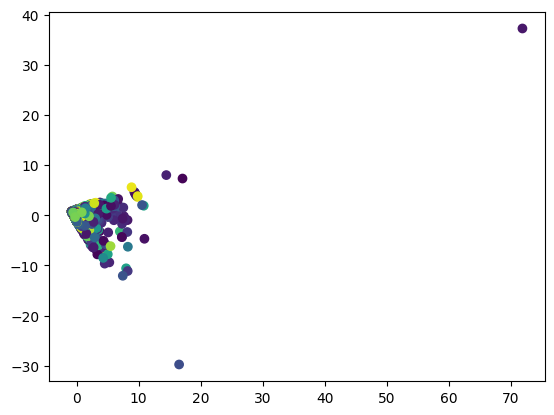

In [99]:
#对数据进行归一化处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num_seqs)
# 以二维空间为例，将数据降为两维
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# 将每个电影在二维空间中绘制出来，并根据它们的聚类结果着色
import matplotlib.pyplot as plt

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters)
plt.show()

In [100]:
#输出是个属于第一类的电影名称
#输出每个电影所属的簇
cnt = 0
for i, cluster in enumerate(clusters):
    #看一下同属第600类的电影
    if cluster == 411:
      print(select_list[i])
      cnt += 1
      if cnt == 10:
        break

['三个男人一只脚', '无', '意大利', '喜剧 单一', 100, 7.7, 1414]
['狂恋吉娜', '无', '意大利', '剧情 单一', 90, 7.5, 2200]
['恐怖蜡像馆', '安德烈·德·托特', '恐怖', '恐怖 单一', 90, 7.3, 1341]
['终站', '维托里奥·德西卡', '意大利', '剧情 爱情', 90, 7.3, 2200]
['欧索多', '保罗·维尔齐', '意大利', '剧情 喜剧', 100, 7.6, 2200]
['骗子', '费德里科·费里尼', '意大利', '剧情 单一', 100, 8.2, 1862]
['杀人鳄鱼潭', '法布里齐奥·德安杰利斯', '恐怖', '恐怖 单一', 90, 7.3, 1341]
['圣米歇尔有只公鸡', '保罗·塔维亚尼/维托里奥·塔维亚尼', '意大利', '剧情 单一', 90, 7.9, 1445]
['黑色共和国', '朴光洙', '韩国', '剧情 单一', 100, 7.3, 2200]
['卡特里娜进城记', '无', '意大利', '剧情 喜剧', 90, 7.7, 1414]


In [101]:
new_df = pd.read_csv('/content/drive/MyDrive/ITNewTech/movie_data.csv', engine='python',encoding='utf-8',on_bad_lines=bad_line ,skip_blank_lines=True) #重新读一遍文件（没分词）
# 删除重复项
new_df = new_df.drop_duplicates()

# 填充缺失值
new_df = new_df.fillna('无')

In [102]:
#通过该模型，做一个有标号的训练集
fanal_list = np.array(new_df).tolist() #直接把源文件转化成一个list准备添加标号
print(fanal_list[:5])
clusters = kmeans.labels_
for i, cluster in enumerate(clusters):
  fanal_list[i].append(cluster) #给每一部电影它对应的标号

print(fanal_list[:5])
# 将列表转换为 DataFrame 对象
out_df = pd.DataFrame(fanal_list, columns=['name', 'director',  'rating', 'category', 'duration', 'tag', 'lables'])
print(out_df[:5])

[['哈利·波特与阿兹卡班的囚徒', '阿方索·卡隆', 8.5, '剧情/奇幻/冒险', 141, '哈利波特/魔幻/英国/HarryPotter/美国/奇幻/2004/成长'], ['霸王别姬', '陈凯歌', 9.6, '剧情/爱情/同性', 171, '经典/人性/文艺/爱情/人生/同志/剧情/文革'], ['青木瓜之味', '陈英雄', 7.8, '剧情/爱情/音乐', 104, '越南/陈英雄/文艺/越南电影/爱情/青木瓜之味/唯美/法国'], ['乡愁', '安德烈·塔可夫斯基', 9.0, '剧情', 125, '塔可夫斯基/俄罗斯/苏联/意大利/AndreiTarkovsky/文艺/安德烈·塔可夫斯基/电影'], ['云上的日子', '米开朗基罗·安东尼奥尼/维姆·文德斯', 7.7, '剧情/爱情/情色', 105, '法国/爱情/情色/意大利/文艺/欧洲/1995/剧情']]
[['哈利·波特与阿兹卡班的囚徒', '阿方索·卡隆', 8.5, '剧情/奇幻/冒险', 141, '哈利波特/魔幻/英国/HarryPotter/美国/奇幻/2004/成长', 882], ['霸王别姬', '陈凯歌', 9.6, '剧情/爱情/同性', 171, '经典/人性/文艺/爱情/人生/同志/剧情/文革', 811], ['青木瓜之味', '陈英雄', 7.8, '剧情/爱情/音乐', 104, '越南/陈英雄/文艺/越南电影/爱情/青木瓜之味/唯美/法国', 291], ['乡愁', '安德烈·塔可夫斯基', 9.0, '剧情', 125, '塔可夫斯基/俄罗斯/苏联/意大利/AndreiTarkovsky/文艺/安德烈·塔可夫斯基/电影', 983], ['云上的日子', '米开朗基罗·安东尼奥尼/维姆·文德斯', 7.7, '剧情/爱情/情色', 105, '法国/爱情/情色/意大利/文艺/欧洲/1995/剧情', 57]]
            name            director  rating  category  duration  \
0  哈利·波特与阿兹卡班的囚徒              阿方索·卡隆     8.5  剧情/奇幻/冒险       141   
1           霸王别姬              

In [105]:
#储存文件聚好类的文件
out_df.to_csv('movie_deep_clustering.csv', index=False, encoding='utf-8')